In [61]:
import numpy as np
from cylp.cy import CyClpSimplex
from cylp.py.modeling.CyLPModel import CyLPModel, CyLPArray
import pandas as pd
import time
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [2]:
# quelques fonctions

def matrix_sum_periods(N, T):
    M = np.zeros((N//T, N))
    for i in range(N//T):
        M[i, i*T:(i+1)*T] = ([1] * T)
    
    return np.matrix(M)

def var_matrix(n):
    M = np.zeros((n-1, n))
    for i in range(n-1):
        M[i,i] = 1
        M[i,i+1] = -1
    return np.matrix(M)

def matrix_rendement(rend_off, rend_on, sites):
    lignes = len(rend_off)
    colonnes = len(rend_off[0])
    
    M = np.empty((lignes, colonnes))
    for i, site in sites.iterrows():
        if site['capacite offshore'] == 'Oui':
            M[i] = rend_off[i]
        else:
            M[i] = rend_on[i]
    
    return np.matrix(M)

def sum_rendement(rend, nb_site):
    sum_rend = np.sum(rend, axis=1)
    c = np.ndarray((nb_site,))
    for i in range(nb_site):
        c[i] = sum_rend[i,0]
    c = CyLPArray(c)
    return c

In [119]:
# chargement des données

nb_site = 642


sites = pd.read_csv('data/Sites.csv')
sites = sites.sort_values('index site')
sites = sites.reset_index()
capacites = sites['capacites'].copy()
capacites = CyLPArray(capacites)


off_cap = sites['capacite offshore']
off_cap = off_cap.replace('Oui', 1)
off_cap = off_cap.replace('Non', 0)
off_cap = CyLPArray(off_cap)


rend_off_entire = np.genfromtxt('data/Rendements_offshore.csv', delimiter=',')
rend_on_entire = np.genfromtxt('data/Rendements_onshore.csv', delimiter=',')

In [134]:
# résolution

N = 24*365
T = 3


rend_off = rend_off_entire[:,:N]
rend_on = rend_on_entire[:,:N]


rend = matrix_rendement(rend_off, rend_on, sites) # (642, N)


variabilitee = var_matrix(N//T) @ matrix_sum_periods(N, T) # (N/T-1, N/T) @ (N/T , N)


P = 500000
to = 0.17
d = 0.02
model = CyLPModel()
x = model.addVariable('x', nb_site)
t = model.addVariable('t', N//T - 1)


sum_t = CyLPArray(np.ones(((N-1)//T,), dtype = int))
sum_x = CyLPArray(np.ones((nb_site,), dtype=int))


model += sum_x * x == P
model += 0 <= x <= capacites
model += off_cap * x == (to*P)
model += (variabilitee @ rend.T) * x - t <= 0
model += (variabilitee @ rend.T) * x + t >= 0 
model += sum_t * t <= (d*P*T*(N//T - 1))


c = sum_rendement(rend, nb_site)
model.objective = -c * x 

s = CyClpSimplex(model)

start = time.time()
print(s.dual())
end = time.time()

sol = s.primalVariableSolution['x']
sol_t = s.primalVariableSolution['t']

optimal


In [133]:
# commentaires de la solution

sol = s.primalVariableSolution['x']
sol_t = s.primalVariableSolution['t']

sol_sum_t = 0
for e in sol_t:
    sol_sum_t += e   


print("N = {}\nP = {}\nT = {}\nd = {}\nto = {}\n".format(N, P, T, d, to))
    
print("Variabilitée moyenne: {:.2f} ({})".format(sol_sum_t/(N//T - 1), "OK" if sol_sum_t/(N//T - 1) - d*P*T <= 1e-3 else "NOT OK"))

print("Puissance installée totale: {:.0f} MW ({})".format(np.sum(sol), "OK" if np.sum(sol) - P < 1e-3 else "NOT OK"))

print("Puissance installée offshore: {:.0f} MW ({})".format(np.dot(np.array(off_cap), sol), "OK" if np.dot(np.array(off_cap), sol) - to*P < 1e-3 else "NOT OK"))

print("Production d'energie totale: {:.0f} GWh".format(-s.objectiveValue/1000))

print("Rendement moyen: {:.2f}%".format(-s.objectiveValue/(P*N)*100))

print("Temps de résolution: {:.0f} min {:.3f} sec".format((end - start)//60, (end - start) % 60))

N = 6570
P = 500000
T = 3
d = 0.02
to = 0.17

Variabilitée moyenne: 30000.00 (OK)
Puissance installée totale: 500000 MW (OK)
Puissance installée offshore: 85000 MW (OK)
Production d'energie totale: 1406904 GWh
Rendement moyen: 42.83%
Temps de résolution: 0 min 47.303 sec


In [135]:
# affichage des résultats sur la carte

text_fig = ["puissance: {:.1f}MW, {:.1f}% de la capacitée (i={})".format(sol[i], sol[i]/sites['capacites'][i]*100, sites['index site'][i]) for i in range(len(sol))]

fig_sol = go.Figure(data=go.Scattergeo(
        lon = sites['longitude'],
        lat = sites['latitude'],
        text = text_fig,
        mode = 'markers',
        marker = dict(size = sol/sol.max()*30)
    ))

fig_sol.update_layout(
        title = 'Puissance installée sur chaque site',
        geo_scope = 'europe'
    )

fig_sol.show()

In [127]:
# temps éxecution en fonction du paramètre N

temps_exec = []
N_vector = np.arange(31*2,365,31*2)
N_vector *= 24
T = 3
R = 1


for N in N_vector:
    
    avrg = 0
    for i in range(R):
        rend_off = rend_off_entire[:,:N]
        rend_on = rend_on_entire[:,:N]


        rend = matrix_rendement(rend_off, rend_on, sites) # (642, N)


        variabilitee = var_matrix(N//T) @ matrix_sum_periods(N, T) # (N/T-1, N/T) @ (N/T , N)


        P = 500000
        to = 0.17
        d = 0.02
        model = CyLPModel()
        x = model.addVariable('x', nb_site)
        t = model.addVariable('t', N//T - 1)


        sum_t = CyLPArray(np.ones((N//T - 1,), dtype = int))
        sum_x = CyLPArray(np.ones((nb_site,), dtype=int))


        model += sum_x * x == P
        model += 0 <= x <= capacites
        model += off_cap * x == (to*P)
        model += (variabilitee @ rend.T) * x - t <= 0
        model += (variabilitee @ rend.T) * x + t >= 0 
        model += sum_t * t <= (d*P*T*(N//T - 1))


        c = sum_rendement(rend, nb_site)
        model.objective = -c * x 


        s = CyClpSimplex(model)


        start = time.time()
        s.dual()
        end = time.time()
        
        print("time:", end-start)
        avrg += end-start
    avrg /= R
    
    print("({}) test with N = {}, average time taken: {:.5f} seconds".format(N//(7*24), N, avrg))
    temps_exec.append(avrg)
    
temps_exec.append("T={}, R={}, P={}, d={}, to={}".format(T,R,P,d,to))

time: 3.814473867416382
(8) test with N = 1488, average time taken: 3.81447 seconds
time: 11.652897357940674
(17) test with N = 2976, average time taken: 11.65290 seconds


KeyboardInterrupt: 

IndexError: list index out of range

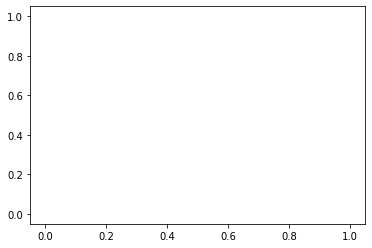

In [118]:
# plot temps d'éxecution

plt.plot(N_vector[:len(temps_exec[:-1])], temps_exec[:-1], 'o-b')
plt.title('temps d\'éxecution en fonction de la taille du problème\n' + temps_exec[-1])
plt.ylabel('temps [s]')
plt.xlabel('N')

plt.savefig('temps.png', bbox_inches='tight')

In [112]:
# écriture dans un fichier des temps d'éxecution

to_write = temps_exec[-1] + '\n'
for i in range(len(temps_exec)-1):
    to_write += "{},{}\n".format(N_vector[i], temps_exec[i])

temps_file = open('temps.txt', 'w')
temps_file.write(to_write)
temps_file.close()